# Simple face recognition

In [4]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io as spio
import scipy.sparse.linalg as ll
import glob
import os
from PIL import Image

#data_path = "./data/yalefaces"
#faces, size = read_faces(data_path, "subject01")

In [7]:
# Read in the images
datadir = './data/yalefaces/'
with_svd = True

In [8]:
im = np.asanyarray(Image.open(datadir+'subject01-test.gif'))
nrow_0, ncol_0 = np.shape(im)  # the original resolution
nrow = np.int32(np.ceil(nrow_0/4.))  # resolution after downsampleing
ncol = np.int32(np.ceil(ncol_0/4.))

s01 = np.empty( (0, nrow*ncol) )
s02 = np.empty( (0, nrow*ncol) )


for f in os.listdir(datadir):
    if f.endswith('.gif'):
        # downsample by 4 when reading-in the image
        im = np.asarray(Image.open(datadir + f))[::4, ::4].reshape(1, -1)
        if f.startswith('subject01'):
            if f.endswith('test.gif'):
                s01_test = im
            else:
                s01 = np.row_stack( (s01, im) )
        elif f.startswith('subject02'):
            if f.endswith('test.gif'):
                s02_test = im
            else:
                s02 = np.row_stack( (s02, im) )    
        else:
            pass

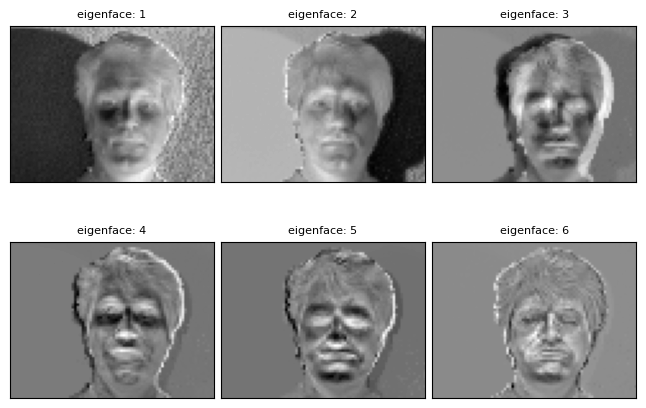

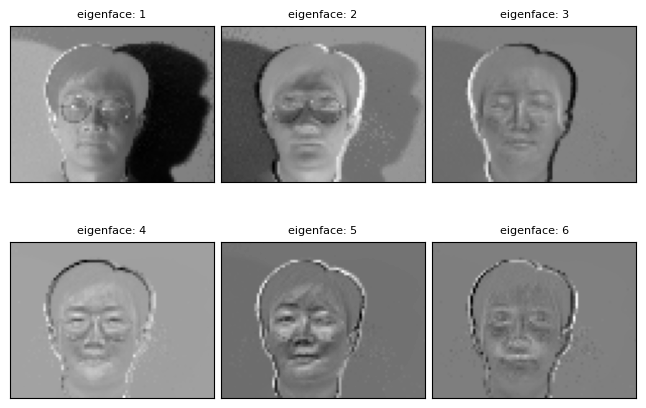

In [11]:


# ## part 1
        
mu01 = np.mean(s01, 0)
mu01 = mu01[np.newaxis,:] 
mu02 = np.mean(s02, 0)
mu02 = mu02[np.newaxis,:]

# subtract mean
x01 = s01-np.tile(mu01, (10, 1))
x02 = s02-np.tile(mu02, (9, 1))

if with_svd:
    # svd on the data matrix
    # this approach assumes images as features
    # and is performed via svd because an eigendecomposition on
    # an npixel x npixel matrix could be computationally prohibitive
    # (it's not extremely so in our case, but it could well be 
    # as npixel grows)
    u01, d01,_ = np.linalg.svd(x01.T)
    u02, d02,_ = np.linalg.svd(x02.T)
    # notice that the eigenvectors from decomposition count as our 
    # eigenfaces for this exercise
    eface01 = u01[:,0:6]
    eface02 = u02[:,0:6]
else:
    # you can also take the covariance assuming images are features,
    # but you would actually have to perform PCA at the end. This method is the alternative 
    # Turk/Pentland describe.
    a01 = np.cov(x01)
    a02 = np.cov(x02)

    eval01, evec01 = np.linalg.eig(a01)
    eval02, evec02 = np.linalg.eig(a02)

    ind1 = np.argsort(eval01)[::-1]
    ind2 = np.argsort(eval02)[::-1]

    u01 = np.real(evec01[:, ind1])
    u02 = np.real(evec02[:, ind2])
    v01 = np.real(eval01[ind1])
    v02 = np.real(eval02[ind2])

    eface01 = u01[:,0:6]
    eface02 = u02[:,0:6]

    eface01 = x01.T @ eface01 @ np.diag((1/np.sqrt(v01[0:6])))
    eface02 = x02.T @ eface02 @ np.diag((1/np.sqrt(v02[0:6])))
 
fig1, ax1 = plt.subplots(2,3)


for ii in range(2):
    for jj in range(3):
        flag = ii*3+jj
        ax1[ii][jj].imshow(np.reshape(eface01[:,flag], (nrow,ncol)), cmap='gray')
        ax1[ii][jj].xaxis.set_visible(False)
        ax1[ii][jj].yaxis.set_visible(False)
        ax1[ii][jj].set_title('eigenface: '+str(ii*3+jj+1), fontsize=8)
fig1.tight_layout(pad=0.5)  

# subject02
fig2, ax2 = plt.subplots(2,3)
for ii in range(2):
    for jj in range(3):
        flag = ii*3+jj
        ax2[ii][jj].imshow(np.reshape(eface02[:,flag], (nrow,ncol)), cmap='gray')
        ax2[ii][jj].xaxis.set_visible(False)
        ax2[ii][jj].yaxis.set_visible(False)
        ax2[ii][jj].set_title('eigenface: '+str(flag+1), fontsize=8)
fig2.tight_layout(pad=0.5)  

plt.show()


## Eigenfaces associated with higher eigenvalues are more identifiable; they tend to show more distinctive features

In [12]:
# ## part 2, part 3


def residual_score(x, ef):
    # require x, ef to be column vectors
    if len(ef.shape)==1: # if only one eigenface, reshape to column
        ef = ef.reshape(-1, 1)
    residual = x - ef@(ef.T@x)
    return np.linalg.norm(residual)**2
    
    

num_eface_batch = [1,2,3, 4, 5, 6]

print('\n with mean subtracted')
for ii in range(len(num_eface_batch)):
    num_eface = num_eface_batch[ii]
    
    s11 = residual_score((s01_test-mu01).T, eface01[:,:num_eface])
    s12 = residual_score((s02_test-mu01).T, eface01[:,:num_eface])
    s21 = residual_score((s01_test-mu02).T, eface02[:,:num_eface])
    s22 = residual_score((s02_test-mu02).T, eface02[:,:num_eface])
    
    
    
    print('\nThe residual score with {} eigenface included'.format(num_eface))
    print('s11:')
    print(format(s11, "5.4e"))
    print('s12:')
    print(format(s12, "5.4e"))
    print('s21:')
    print(format(s21, "5.4e"))
    print('s22:')
    print(format(s22, "5.4e"))

print('\n without mean subtracted')
for ii in range(len(num_eface_batch)):
    num_eface = num_eface_batch[ii]
    
    s11 = residual_score(s01_test.T, eface01[:,:num_eface])
    s12 = residual_score(s02_test.T, eface01[:,:num_eface])
    s21 = residual_score(s01_test.T, eface02[:,:num_eface])
    s22 = residual_score(s02_test.T, eface02[:,:num_eface])
    
    
    
    print('\nThe residual score with {} eigenface included'.format(num_eface))
    print('s11:')
    print(format(s11, "5.4e"))
    print('s12:')
    print(format(s12, "5.4e"))
    print('s21:')
    print(format(s21, "5.4e"))
    print('s22:')
    print(format(s22, "5.4e"))


 with mean subtracted

The residual score with 1 eigenface included
s11:
7.2016e+06
s12:
4.0638e+07
s21:
3.3747e+07
s22:
4.2425e+06

The residual score with 2 eigenface included
s11:
6.5665e+06
s12:
3.6413e+07
s21:
3.3698e+07
s22:
4.2279e+06

The residual score with 3 eigenface included
s11:
6.2235e+06
s12:
3.5899e+07
s21:
3.3477e+07
s22:
2.8448e+06

The residual score with 4 eigenface included
s11:
6.1941e+06
s12:
3.5573e+07
s21:
3.3220e+07
s22:
2.7908e+06

The residual score with 5 eigenface included
s11:
6.1166e+06
s12:
3.5450e+07
s21:
3.3139e+07
s22:
2.7206e+06

The residual score with 6 eigenface included
s11:
6.0913e+06
s12:
3.5237e+07
s21:
3.1949e+07
s22:
2.5600e+06

 without mean subtracted

The residual score with 1 eigenface included
s11:
4.9933e+07
s12:
1.1395e+08
s21:
1.9976e+08
s22:
1.8197e+08

The residual score with 2 eigenface included
s11:
3.1567e+07
s12:
6.2999e+07
s21:
1.1613e+08
s22:
9.6473e+07

The residual score with 3 eigenface included
s11:
3.1283e+07
s12:
6.25

## Residuals scores mean subtracted 